In [4]:
%pylab inline
import pandas as pd
import fastparquet 
import os,sys

Populating the interactive namespace from numpy and matplotlib


In [5]:
import lightgbm as lgb

In [6]:
if 0:
    sys.path.insert(0,os.getcwd()+"/../../src/main")
else:
    sys.path.insert(0, "/mnt/lanlep2019/src/main")
    os.environ['LOCAL']="/mnt/local"

In [7]:
!echo $LOCAL

/mnt/local


In [8]:
!mkdir -p $LOCAL/sandbox

In [9]:
HOME=os.environ['LOCAL']+"/sandbox"
os.chdir(HOME)
os.getcwd()

'/mnt/local/sandbox'

In [10]:
os.environ['LANLEP_HOME']=HOME

In [11]:
import data

In [24]:
if 0:
    !ls /home/lizhen09/lanlep2019/input/feat/*.parq | grep -v offset_.parq | xargs -L1  -IINPUT cp INPUT {HOME}/input/feat/
else:
    !cd {HOME}/input/feat/ && cat /mnt/lizhen-east2/notebook/fastseq/5/tmp.tar | tar xf - 
    !cd {HOME}/input/feat/ && cat /mnt/lizhen-east2/notebook/fastseq/5/tmppkl.tar | tar xf -     

In [32]:
reload (data)

<module 'data' from '/mnt/lanlep2019/src/main/data.py'>

In [12]:
if 1:
    strategy = {'type':'rand', "fold":5}
    types=['fwv']
    traintest = data.TrainTest('offset', offset=0, types=types, transform=None, valid_strategy=strategy)

In [13]:
traintest.num_dataset()

5

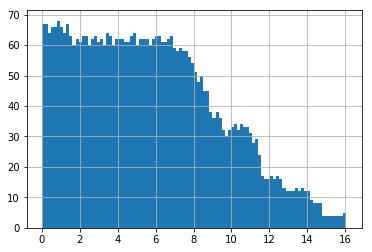

In [14]:
traintest.ydf.hist(bins=100);

In [15]:
np.abs(traintest.ydf-traintest.ydf.median()).mean()

3.032763197384022

In [16]:
testdf=traintest.get_test_data()
testdf.shape

(2624, 100)

In [17]:
datadf=pd.concat([traintest.traindf, traintest.ydf],axis=1)
print datadf.shape
datadf.head()

(4184, 101)


fwv_0     fwv_1     fwv_2     fwv_3     fwv_4     fwv_5  \
index                                                                       
quake_07_0405  0.177243  0.148722  0.101298 -0.151453  0.118340  0.085533   
quake_07_0404  0.175916  0.208865  0.121425 -0.149945  0.078927 -0.033455   
quake_07_0159  0.123625  0.259964  0.114662 -0.177983  0.076714 -0.008650   
quake_07_0158  0.127892  0.236912  0.120239 -0.147701  0.065033 -0.029501   
quake_07_0401  0.168152  0.240921  0.146662 -0.184900  0.126381  0.005611   

                  fwv_6     fwv_7     fwv_8     fwv_9    ...       fwv_91  \
index                                                    ...                
quake_07_0405 -0.126488  0.383367  0.184891 -0.182000    ...     0.276661   
quake_07_0404 -0.001732  0.259981  0.170118 -0.146734    ...     0.182124   
quake_07_0159  0.029887  0.234569  0.166675 -0.139920    ...     0.131131   
quake_07_0158  0.007605  0.238272  0.166551 -0.104213    ...     0.158076   
quake_07_0401  0.008869  0.288528  0.169460 -0.190870    ...     0.173906   

                 fwv_92    fwv_93    fwv_94    fwv_95    fwv_96    fwv_97  \
index                                                                       
quake_07_0405 -0.040588 -0.079376 -0.185854  0.031153  0.011661 -0.177359   
quake_07_0404  0.020085  0.007380 -0.045135  0.012951  0.022898 -0.136806   
quake_07_0159  0.068873  0.045272  0.115157  0.038833  0.072388 -0.109722   
quake_07_0158  0.011800  0.050090  0.066010  0.055765  0.051091 -0.113880   
quake_07_0401  0.000818  0.020374 -0.018780  0.006945  0.040418 -0.139294   

                 fwv_98    fwv_99         y  
index                                        
quake_07_0405  0.021507  0.143021  0.287999  
quake_07_0404  0.015471  0.179152  0.327298  
quake_07_0159 -0.035507  0.092227  9.873498  
quake_07_0158  0.000226  0.118060  9.912896  
quake_07_0401 -0.030202  0.189248  0.444397  

[5 rows x 101 columns]

In [18]:
datadf= datadf[~datadf.index.duplicated(keep='first')]
datadf=datadf.iloc[np.random.permutation(range(len(datadf)))]
datadf.shape

(4184, 101)

In [19]:
ydf=traintest.ydf
ydf.head()

index
quake_07_0405    0.287999
quake_07_0404    0.327298
quake_07_0159    9.873498
quake_07_0158    9.912896
quake_07_0401    0.444397
Name: y, dtype: float64

In [20]:
qdf=pd.DataFrame(datadf.index.map(lambda u: u.split("_")[1]).astype(np.int8),index=datadf.index)
qdf.head()

index
index               
quake_00_0008      0
quake_10_0291     10
quake_12_0079     12
quake_01_0288      1
quake_09_0031      9

In [21]:
qdf=qdf[~qdf['index'].isin({0,16})]
datadf=datadf.loc[qdf.index]
ydf=datadf['y']
datadf=datadf.drop('y',axis=1)
qdf.shape,datadf.shape,ydf.shape

((4100, 1), (4100, 100), (4100,))

In [22]:
qdf['index'].value_counts().to_frame().sort_index().T

1    2    3    4    5    6    7    8    9    10   11   12   13   14  \
index  296  363  227  325  206  181  413  202  247  293  282  226  219  378   

        15  
index  242

In [23]:
qlen=qdf['index'].value_counts().to_dict()
str(qlen)

'{1: 296, 2: 363, 3: 227, 4: 325, 5: 206, 6: 181, 7: 413, 8: 202, 9: 247, 10: 293, 11: 282, 12: 226, 13: 219, 14: 378, 15: 242}'

In [24]:
quakes=set(qdf['index'])
quakes

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}

In [28]:
import utils
n_thread= utils.get_num_thread()
n_thread

15

In [26]:
n_thread=3

In [27]:
params = {'num_leaves': 54,
          #'min_data_in_leaf': 79,
          'objective': 'huber',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8126672064208567,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501
         }

In [29]:
from sklearn import model_selection


In [50]:
testpred=[]
exqnos={2}
if 1:
    print 'excludes ', exqnos
    dataidx=~(qdf['index'].isin(exqnos))
    X=datadf[dataidx]
    Y=ydf[dataidx]
    kf = model_selection.KFold(n_splits=5,shuffle=True)
    for train_index, test_index in kf.split(X):
        Xtr,ytr,Xte,yte=X.iloc[train_index],Y.iloc[train_index],X.iloc[test_index],Y.iloc[test_index],
        Xtr,ytr,Xte,yte=[u.values for u in [Xtr,ytr,Xte,yte]]
        print Xtr.shape,ytr.shape,Xte.shape,yte.shape
        model = lgb.LGBMRegressor(n_estimators = 50000, n_jobs = n_thread, **params)
        model.fit(Xtr, ytr, 
                        eval_set=[(Xtr, ytr), (Xte, yte)], eval_metric='mae',
                        verbose=50, early_stopping_rounds=200)
        a = model.predict(testdf.values,  num_iteration=model.best_iteration_)
        testpred.append(a)

excludes  set([2])
(2989, 100) (2989,) (748, 100) (748,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 2.69643	valid_1's l1: 2.73198
[100]	training's l1: 2.48545	valid_1's l1: 2.56771
[150]	training's l1: 2.29747	valid_1's l1: 2.4258
[200]	training's l1: 2.13038	valid_1's l1: 2.30654
[250]	training's l1: 1.98491	valid_1's l1: 2.2067
[300]	training's l1: 1.85947	valid_1's l1: 2.12976
[350]	training's l1: 1.74972	valid_1's l1: 2.06675
[400]	training's l1: 1.65815	valid_1's l1: 2.01971
[450]	training's l1: 1.57815	valid_1's l1: 1.9874
[500]	training's l1: 1.5084	valid_1's l1: 1.9672
[550]	training's l1: 1.4443	valid_1's l1: 1.95564
[600]	training's l1: 1.38531	valid_1's l1: 1.94842
[650]	training's l1: 1.33144	valid_1's l1: 1.9438
[700]	training's l1: 1.28152	valid_1's l1: 1.93766
[750]	training's l1: 1.23344	valid_1's l1: 1.93477
[800]	training's l1: 1.18859	valid_1's l1: 1.93433
[850]	training's l1: 1.14562	valid_1's l1: 1.93291
[900]	training's l1: 

5.487988104586883 5.234933550216747


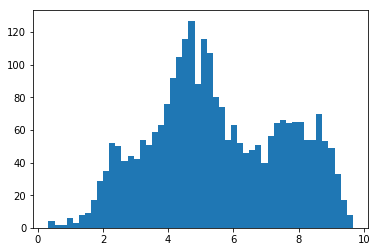

In [51]:
pred = np.median(np.array(testpred).T,1)
print np.mean(pred),np.median(pred)
plt.hist(pred,bins=50);

In [52]:
a=pd.DataFrame(pred,index=testdf.index).reset_index()
a.columns=["seg_id","time_to_failure"]
print a.shape
a.to_csv(os.environ['LOCAL']+"/input/sub/test_fwv_nonovp_5fold_lgb_median_rm-2.csv",index=None)

(2624, 2)


In [54]:
testpred=[]
exqnos={7}
if 1:
    print 'excludes ', exqnos
    dataidx=~(qdf['index'].isin(exqnos))
    X=datadf[dataidx]
    Y=ydf[dataidx]
    kf = model_selection.KFold(n_splits=5,shuffle=True)
    for train_index, test_index in kf.split(X):
        Xtr,ytr,Xte,yte=X.iloc[train_index],Y.iloc[train_index],X.iloc[test_index],Y.iloc[test_index],
        Xtr,ytr,Xte,yte=[u.values for u in [Xtr,ytr,Xte,yte]]
        print Xtr.shape,ytr.shape,Xte.shape,yte.shape
        model = lgb.LGBMRegressor(n_estimators = 50000, n_jobs = n_thread, **params)
        model.fit(Xtr, ytr, 
                        eval_set=[(Xtr, ytr), (Xte, yte)], eval_metric='mae',
                        verbose=50, early_stopping_rounds=200)
        a = model.predict(testdf.values,  num_iteration=model.best_iteration_)
        testpred.append(a)

excludes  set([7])
(2949, 100) (2949,) (738, 100) (738,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 2.58062	valid_1's l1: 2.6987
[100]	training's l1: 2.3697	valid_1's l1: 2.53344
[150]	training's l1: 2.17894	valid_1's l1: 2.38769
[200]	training's l1: 2.00968	valid_1's l1: 2.26547
[250]	training's l1: 1.86229	valid_1's l1: 2.16512
[300]	training's l1: 1.73648	valid_1's l1: 2.08356
[350]	training's l1: 1.62968	valid_1's l1: 2.02366
[400]	training's l1: 1.54018	valid_1's l1: 1.98035
[450]	training's l1: 1.46335	valid_1's l1: 1.94684
[500]	training's l1: 1.39342	valid_1's l1: 1.9224
[550]	training's l1: 1.33113	valid_1's l1: 1.90345
[600]	training's l1: 1.27359	valid_1's l1: 1.89203
[650]	training's l1: 1.22122	valid_1's l1: 1.88114
[700]	training's l1: 1.17172	valid_1's l1: 1.87396
[750]	training's l1: 1.12501	valid_1's l1: 1.86815
[800]	training's l1: 1.08149	valid_1's l1: 1.8639
[850]	training's l1: 1.04031	valid_1's l1: 1.85877
[900]	training's l

5.190636547792532 4.952217487540856


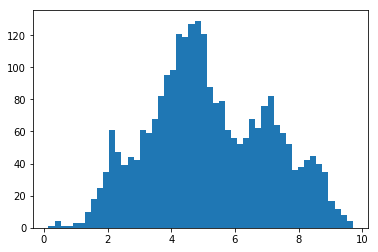

In [55]:
pred = np.median(np.array(testpred).T,1)
print np.mean(pred),np.median(pred)
plt.hist(pred,bins=50);

In [61]:
a=pd.DataFrame(pred,index=testdf.index).reset_index()
a.columns=["seg_id","time_to_failure"]
print a.shape
a.to_csv(os.environ['LOCAL']+"/input/sub/test_fwv_nonovp_5fold_lgb_median_rm-{}.csv".format("-".join([str(u) for u in exqnos])),index=None)

(2624, 2)


In [63]:
testpred=[]
exqnos={14}
if 1:
    print 'excludes ', exqnos
    dataidx=~(qdf['index'].isin(exqnos))
    X=datadf[dataidx]
    Y=ydf[dataidx]
    kf = model_selection.KFold(n_splits=5,shuffle=True)
    for train_index, test_index in kf.split(X):
        Xtr,ytr,Xte,yte=X.iloc[train_index],Y.iloc[train_index],X.iloc[test_index],Y.iloc[test_index],
        Xtr,ytr,Xte,yte=[u.values for u in [Xtr,ytr,Xte,yte]]
        print Xtr.shape,ytr.shape,Xte.shape,yte.shape
        model = lgb.LGBMRegressor(n_estimators = 50000, n_jobs = n_thread, **params)
        model.fit(Xtr, ytr, 
                        eval_set=[(Xtr, ytr), (Xte, yte)], eval_metric='mae',
                        verbose=50, early_stopping_rounds=200)
        a = model.predict(testdf.values,  num_iteration=model.best_iteration_)
        testpred.append(a)

excludes  set([14])
(2977, 100) (2977,) (745, 100) (745,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 2.67813	valid_1's l1: 2.67017
[100]	training's l1: 2.46451	valid_1's l1: 2.50385
[150]	training's l1: 2.27389	valid_1's l1: 2.36466
[200]	training's l1: 2.10309	valid_1's l1: 2.24506
[250]	training's l1: 1.95427	valid_1's l1: 2.14793
[300]	training's l1: 1.82536	valid_1's l1: 2.07479
[350]	training's l1: 1.71358	valid_1's l1: 2.02012
[400]	training's l1: 1.62065	valid_1's l1: 1.98232
[450]	training's l1: 1.54143	valid_1's l1: 1.9567
[500]	training's l1: 1.47092	valid_1's l1: 1.93896
[550]	training's l1: 1.40839	valid_1's l1: 1.92696
[600]	training's l1: 1.34973	valid_1's l1: 1.91903
[650]	training's l1: 1.29628	valid_1's l1: 1.91175
[700]	training's l1: 1.24631	valid_1's l1: 1.90808
[750]	training's l1: 1.19918	valid_1's l1: 1.90602
[800]	training's l1: 1.1538	valid_1's l1: 1.90456
[850]	training's l1: 1.11143	valid_1's l1: 1.90329
[900]	training'

5.134183403276065 4.610924587448895


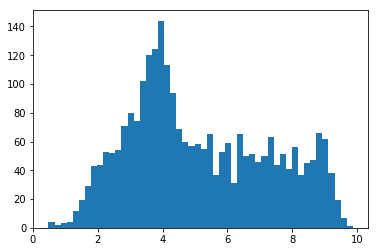

In [64]:
pred = np.median(np.array(testpred).T,1)
print np.mean(pred),np.median(pred)
plt.hist(pred,bins=50);

In [65]:
a=pd.DataFrame(pred,index=testdf.index).reset_index()
a.columns=["seg_id","time_to_failure"]
print a.shape
a.to_csv(os.environ['LOCAL']+"/input/sub/test_fwv_nonovp_5fold_lgb_median_rm-{}.csv".format("-".join([str(u) for u in exqnos])),index=None)

(2624, 2)


In [66]:
testpred=[]
exqnos={4}
if 1:
    print 'excludes ', exqnos
    dataidx=~(qdf['index'].isin(exqnos))
    X=datadf[dataidx]
    Y=ydf[dataidx]
    kf = model_selection.KFold(n_splits=5,shuffle=True)
    for train_index, test_index in kf.split(X):
        Xtr,ytr,Xte,yte=X.iloc[train_index],Y.iloc[train_index],X.iloc[test_index],Y.iloc[test_index],
        Xtr,ytr,Xte,yte=[u.values for u in [Xtr,ytr,Xte,yte]]
        print Xtr.shape,ytr.shape,Xte.shape,yte.shape
        model = lgb.LGBMRegressor(n_estimators = 50000, n_jobs = n_thread, **params)
        model.fit(Xtr, ytr, 
                        eval_set=[(Xtr, ytr), (Xte, yte)], eval_metric='mae',
                        verbose=50, early_stopping_rounds=200)
        a = model.predict(testdf.values,  num_iteration=model.best_iteration_)
        testpred.append(a)

excludes  set([4])
(3020, 100) (3020,) (755, 100) (755,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 2.7634	valid_1's l1: 2.76994
[100]	training's l1: 2.56082	valid_1's l1: 2.60017
[150]	training's l1: 2.3769	valid_1's l1: 2.45768
[200]	training's l1: 2.21514	valid_1's l1: 2.33346
[250]	training's l1: 2.07028	valid_1's l1: 2.23302
[300]	training's l1: 1.94189	valid_1's l1: 2.1553
[350]	training's l1: 1.83117	valid_1's l1: 2.09758
[400]	training's l1: 1.73779	valid_1's l1: 2.05468
[450]	training's l1: 1.65756	valid_1's l1: 2.02432
[500]	training's l1: 1.5869	valid_1's l1: 2.00574
[550]	training's l1: 1.52587	valid_1's l1: 1.99211
[600]	training's l1: 1.4693	valid_1's l1: 1.9821
[650]	training's l1: 1.41573	valid_1's l1: 1.97483
[700]	training's l1: 1.36545	valid_1's l1: 1.97006
[750]	training's l1: 1.31766	valid_1's l1: 1.96732
[800]	training's l1: 1.27235	valid_1's l1: 1.96632
[850]	training's l1: 1.22927	valid_1's l1: 1.96418
[900]	training's l1:

5.529113231690454 5.28789383365695


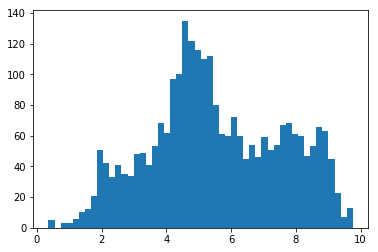

In [67]:
pred = np.median(np.array(testpred).T,1)
print np.mean(pred),np.median(pred)
plt.hist(pred,bins=50);

In [68]:
a=pd.DataFrame(pred,index=testdf.index).reset_index()
a.columns=["seg_id","time_to_failure"]
print a.shape
a.to_csv(os.environ['LOCAL']+"/input/sub/test_fwv_nonovp_5fold_lgb_median_rm-{}.csv".format("-".join([str(u) for u in exqnos])),index=None)

(2624, 2)


In [69]:
testpred=[]
exqnos={1}
if 1:
    print 'excludes ', exqnos
    dataidx=~(qdf['index'].isin(exqnos))
    X=datadf[dataidx]
    Y=ydf[dataidx]
    kf = model_selection.KFold(n_splits=5,shuffle=True)
    for train_index, test_index in kf.split(X):
        Xtr,ytr,Xte,yte=X.iloc[train_index],Y.iloc[train_index],X.iloc[test_index],Y.iloc[test_index],
        Xtr,ytr,Xte,yte=[u.values for u in [Xtr,ytr,Xte,yte]]
        print Xtr.shape,ytr.shape,Xte.shape,yte.shape
        model = lgb.LGBMRegressor(n_estimators = 50000, n_jobs = n_thread, **params)
        model.fit(Xtr, ytr, 
                        eval_set=[(Xtr, ytr), (Xte, yte)], eval_metric='mae',
                        verbose=50, early_stopping_rounds=200)
        a = model.predict(testdf.values,  num_iteration=model.best_iteration_)
        testpred.append(a)

excludes  set([1])
(3043, 100) (3043,) (761, 100) (761,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 2.77312	valid_1's l1: 2.88742
[100]	training's l1: 2.56607	valid_1's l1: 2.74283
[150]	training's l1: 2.38103	valid_1's l1: 2.61692
[200]	training's l1: 2.21715	valid_1's l1: 2.50597
[250]	training's l1: 2.07426	valid_1's l1: 2.41112
[300]	training's l1: 1.94842	valid_1's l1: 2.33258
[350]	training's l1: 1.84125	valid_1's l1: 2.27106
[400]	training's l1: 1.74867	valid_1's l1: 2.22946
[450]	training's l1: 1.6681	valid_1's l1: 2.19613
[500]	training's l1: 1.5983	valid_1's l1: 2.1723
[550]	training's l1: 1.53501	valid_1's l1: 2.15362
[600]	training's l1: 1.47871	valid_1's l1: 2.13901
[650]	training's l1: 1.42567	valid_1's l1: 2.12916
[700]	training's l1: 1.3771	valid_1's l1: 2.12272
[750]	training's l1: 1.32895	valid_1's l1: 2.11993
[800]	training's l1: 1.28361	valid_1's l1: 2.11675
[850]	training's l1: 1.24123	valid_1's l1: 2.11334
[900]	training's l

5.478474274772574 5.175431204125825


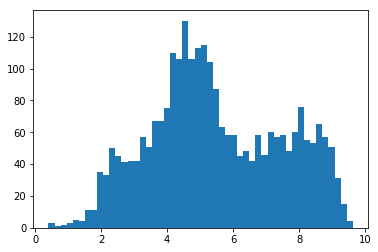

In [70]:
pred = np.median(np.array(testpred).T,1)
print np.mean(pred),np.median(pred)
plt.hist(pred,bins=50);

In [71]:
a=pd.DataFrame(pred,index=testdf.index).reset_index()
a.columns=["seg_id","time_to_failure"]
print a.shape
a.to_csv(os.environ['LOCAL']+"/input/sub/test_fwv_nonovp_5fold_lgb_median_rm-{}.csv".format("-".join([str(u) for u in exqnos])),index=None)

(2624, 2)


In [30]:
testpred=[]
exqnos={2,4}
if 1:
    print 'excludes ', exqnos
    dataidx=~(qdf['index'].isin(exqnos))
    X=datadf[dataidx]
    Y=ydf[dataidx]
    kf = model_selection.KFold(n_splits=5,shuffle=True)
    for train_index, test_index in kf.split(X):
        Xtr,ytr,Xte,yte=X.iloc[train_index],Y.iloc[train_index],X.iloc[test_index],Y.iloc[test_index],
        Xtr,ytr,Xte,yte=[u.values for u in [Xtr,ytr,Xte,yte]]
        print Xtr.shape,ytr.shape,Xte.shape,yte.shape
        model = lgb.LGBMRegressor(n_estimators = 50000, n_jobs = n_thread, **params)
        model.fit(Xtr, ytr, 
                        eval_set=[(Xtr, ytr), (Xte, yte)], eval_metric='mae',
                        verbose=50, early_stopping_rounds=200)
        a = model.predict(testdf.values,  num_iteration=model.best_iteration_)
        testpred.append(a)

excludes  set([2, 4])
(2729, 100) (2729,) (683, 100) (683,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 2.6463	valid_1's l1: 2.72358
[100]	training's l1: 2.42476	valid_1's l1: 2.55949
[150]	training's l1: 2.22696	valid_1's l1: 2.41663
[200]	training's l1: 2.05278	valid_1's l1: 2.29668
[250]	training's l1: 1.90035	valid_1's l1: 2.20286
[300]	training's l1: 1.77014	valid_1's l1: 2.1321
[350]	training's l1: 1.66183	valid_1's l1: 2.08233
[400]	training's l1: 1.57092	valid_1's l1: 2.04734
[450]	training's l1: 1.49257	valid_1's l1: 2.0202
[500]	training's l1: 1.42494	valid_1's l1: 2.00323
[550]	training's l1: 1.36358	valid_1's l1: 1.98939
[600]	training's l1: 1.30651	valid_1's l1: 1.98222
[650]	training's l1: 1.25464	valid_1's l1: 1.9762
[700]	training's l1: 1.20617	valid_1's l1: 1.97627
[750]	training's l1: 1.1589	valid_1's l1: 1.97519
[800]	training's l1: 1.1152	valid_1's l1: 1.97813
[850]	training's l1: 1.07433	valid_1's l1: 1.97961
[900]	training's 

5.459915104018263 5.209017759033993


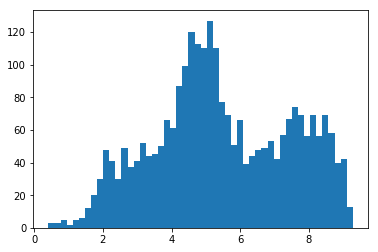

In [31]:
pred = np.median(np.array(testpred).T,1)
print np.mean(pred),np.median(pred)
plt.hist(pred,bins=50);

In [32]:
a=pd.DataFrame(pred,index=testdf.index).reset_index()
a.columns=["seg_id","time_to_failure"]
print a.shape
a.to_csv(os.environ['LOCAL']+"/input/sub/test_fwv_nonovp_5fold_lgb_median_rm-{}.csv".format("-".join([str(u) for u in exqnos])),index=None)

(2624, 2)
